# Final Project - Multilingual Bert Named Entity Recognition
In this notebook, we will deal with the task of fine-tuning Transformers model to a token classification where we will predict a label for each token. 


# 1.0. Setup

Install Transformers and datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install seqeval

Import relavent libraries that we will be using

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns 
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, Dataset, DataLoader
from transformers import BertConfig, BertModel, AutoTokenizer
from datasets import load_dataset, load_metric, ClassLabel
from seqeval.metrics import f1_score, classification_report

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

languages = ["en", "es", "nl", "de", "da", "afr", "sv", "fr", "it", "pt", "tr", "ru", "he", "ar", "zh", "ja", "ko"]

model_name = 'bert-base-multilingual-cased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

# 2.0. Data Preprocessing

First, we preprocess the data. This is done by a 🤗 Transformers Tokenizer which will tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

In [ ]:
def preprocess(dataset):
    tokenized_inputs = tokenizer(dataset["tokens"], padding='max_length', truncation=True, is_split_into_words=True, max_length=MAX_LEN)
    
    label_all_tokens = True

    labels = []
    for i, label in enumerate(dataset["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Word ID of special tokens is None. We set the label to -100 since it is automatically ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, depending on the label_all_tokens flag, we set the label to either the current label or -100.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["ner_tags"] = labels
    return tokenized_inputs

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation.
A Dataset object is a dictionary containing one key for each of the training, test and validation sets (possibly less). 

We use the following datasets:

*   English- CONLL 2003
*   Spanish- CONLL 2002
*   Dutch- CONLL 2002
*   German- GermaNER (based on the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) dataset)
*   Danish- DaNE
*   Afrikaans- Afrikaans NER Corpus

All these datasets share the CONLL annotations standard: 

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In addition we use some datasets that are missing the B-MISC and the I-MISC labels:

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

These datasets are:

*   Swedish- WikiANN
*   French- WikiANN
*   Italian- WikiANN
*   Portuguese- WikiANN
*   Turkish- WikiANN
*   Russian- WikiANN
*   Hebrew- WikiANN
*   Arabic- WikiANN
*   Chinese - MSRA NER
*   Japanese - WikiANN
*   Korean - WikiANN

## 2.1. English

In [ ]:
datasets_en = load_dataset("conll2003")

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


We have the following labels inside our dataset:

0 corresponds to 'O' (no special entity), 1 to 'B-PER', 2 to 'I-PER' and so on. In addition to label 'O', there are four other labels for Named Entity Recognition, each with different prefixes: 'B-' (for beginning),'I-' (for intermediate), indicating whether the token is the first one for the current group with the label or not.

The labels:
'PER' - person
'ORG' - organization
'LOC' - location
'MISC' - miscellaneous

In [ ]:
label_list = datasets_en["train"].features["ner_tags"].feature.names
NUM_LABELS = len(label_list)
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

That's how our data looks like (the other datasets are similar):

In [ ]:
df = pd.DataFrame.from_dict(datasets_en["train"])
df

,chunk_tags,id,ner_tags,pos_tags,tokens
0,"[11, 21, 11, 12, 21, 22, 11, 12, 0]",0,"[3, 0, 7, 0, 0, 0, 7, 0, 0]","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[EU, rejects, German, call, to, boycott, Briti..."
1,"[11, 12]",1,"[1, 2]","[22, 22]","[Peter, Blackburn]"
2,"[11, 12]",2,"[5, 0]","[22, 11]","[BRUSSELS, 1996-08-22]"
3,"[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...",3,"[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[The, European, Commission, said, on, Thursday..."
4,"[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...",4,"[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[Germany, 's, representative, to, the, Europea..."
...,...,...,...,...,...
14036,"[13, 11, 0]",14036,"[0, 0, 0]","[15, 22, 8]","[on, Friday, :]"
14037,"[11, 12]",14037,"[0, 0]","[21, 11]","[Division, two]"
14038,"[11, 12, 12, 12]",14038,"[3, 0, 3, 0]","[21, 11, 22, 11]","[Plymouth, 2, Preston, 1]"
14039,"[11, 12]",14039,"[0, 0]","[21, 11]","[Division, three]"


To apply the preprocess function to all the sentences  in the dataset, we have to use the 'map' method of the dataset object. The 'map' method will apply the preprocessing to all the elements of all the splits in dataset. Therefore, the training, validation and testing sets will all be preprocessed after this command.

In [ ]:
tokenized_datasets_en = datasets_en.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-be978bd8eeba9de3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-160cf5c9d95f28e2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-d31d7c38de5bc776.arrow


We seperate the set into train and test (we won't be using the validation set in this experiment) and we remove the irrelevant columns.

In [ ]:
tokenized_en_train = tokenized_datasets_en["train"].map(remove_columns=['pos_tags', 'chunk_tags', 'id'])
tokenized_en_test = tokenized_datasets_en["test"].map(remove_columns=['pos_tags', 'chunk_tags', 'id'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-ea268c878ee6b6bf.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-739223641cbc78b9.arrow


In [ ]:
df_en_train = pd.DataFrame.from_dict(tokenized_en_train)
df_en_test = pd.DataFrame.from_dict(tokenized_en_test)

We can see below how the tokenized sentences look like after the preprocessing. That is, with attention mask, input ids, ner tags and token type ids. 

In [ ]:
df_en_train

,attention_mask,input_ids,ner_tags,token_type_ids,tokens
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[101, 17751, 11639, 93376, 12026, 20575, 10114...","[-100, 3, 0, 0, 7, 0, 0, 0, 0, 7, 0, 0, 0, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[EU, rejects, German, call, to, boycott, Briti..."
1,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 10979, 46006, 102, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 1, 2, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Peter, Blackburn]"
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[101, 49351, 32612, 39039, 66934, 10389, 118, ...","[-100, 5, 5, 5, 5, 0, 0, 0, 0, 0, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[BRUSSELS, 1996-08-22]"
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10117, 11914, 14941, 12415, 10135, 67067...","[-100, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[The, European, Commission, said, on, Thursday..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 12775, 112, 187, 33786, 10114, 10105, 11...","[-100, 5, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Germany, 's, representative, to, the, Europea..."
...,...,...,...,...,...
14036,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 10135, 30767, 131, 102, 0, 0, 0, 0, 0, 0...","[-100, 0, 0, 0, -100, -100, -100, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[on, Friday, :]"
14037,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 11987, 10551, 102, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 0, 0, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Division, two]"
14038,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 40814, 123, 35119, 122, 102, 0, 0, 0, 0,...","[-100, 3, 0, 3, 0, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Plymouth, 2, Preston, 1]"
14039,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 11987, 11003, 102, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 0, 0, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Division, three]"


Since we are operating in pytorch, we have to convert the dataset to torch tensors.

In [ ]:
def create_trainloader_and_testloader(df_train, df_test):
  ids_train = torch.tensor(df_train["input_ids"].tolist(), dtype=torch.long)
  token_type_ids_train = torch.tensor(df_train["token_type_ids"].tolist(), dtype=torch.long)
  mask_train = torch.tensor(df_train["attention_mask"].tolist(), dtype=torch.long)
  tags_train = torch.tensor(df_train["ner_tags"].tolist(), dtype=torch.long)

  ids_test = torch.tensor(df_test["input_ids"].tolist(), dtype=torch.long)
  token_type_ids_test = torch.tensor(df_test["token_type_ids"].tolist(), dtype=torch.long)
  mask_test = torch.tensor(df_test["attention_mask"].tolist(), dtype=torch.long)
  tags_test = torch.tensor(df_test["ner_tags"].tolist(), dtype=torch.long)

  trainset = TensorDataset(ids_train, token_type_ids_train, mask_train, tags_train)
  testset = TensorDataset(ids_test, token_type_ids_test, mask_test, tags_test)

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)

  testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)

  return trainloader, testloader

In [ ]:
trainloader_en, testloader_en = create_trainloader_and_testloader(df_en_train, df_en_test)

## 2.2. Spanish

In [ ]:
datasets_es = load_dataset("conll2002", "es")

Reusing dataset conll2002 (/root/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5)


In [ ]:
tokenized_datasets_es = datasets_es.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-e7af99e10665eb41.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-af3d0ba26d1921ba.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-785f5ff7a728886f.arrow


In [ ]:
tokenized_es_train = tokenized_datasets_es["train"].map(remove_columns=['pos_tags', 'id'])
tokenized_es_test = tokenized_datasets_es["test"].map(remove_columns=['pos_tags', 'id'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-603c650189b54ee8.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-7ccd2ceabadc6715.arrow


In [ ]:
df_es_train = pd.DataFrame.from_dict(tokenized_es_train)
df_es_test = pd.DataFrame.from_dict(tokenized_es_test)

trainloader_es, testloader_es = create_trainloader_and_testloader(df_es_train, df_es_test)

## 2.3. Dutch

In [ ]:
datasets_nl = load_dataset("conll2002", "nl")

Reusing dataset conll2002 (/root/.cache/huggingface/datasets/conll2002/nl/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5)


In [ ]:
tokenized_datasets_nl = datasets_nl.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/nl/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-46c07b6a2443538c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/nl/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-5868f82859a37faa.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/nl/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-ca02000eb619b384.arrow


In [ ]:
tokenized_nl_train = tokenized_datasets_nl["train"].map(remove_columns=['pos_tags', 'id'])
tokenized_nl_test = tokenized_datasets_nl["test"].map(remove_columns=['pos_tags', 'id'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/nl/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-38f9dacfa74dd0e1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2002/nl/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5/cache-70a68789d9b427e5.arrow


In [ ]:
df_nl_train = pd.DataFrame.from_dict(tokenized_nl_train)
df_nl_test = pd.DataFrame.from_dict(tokenized_nl_test)

trainloader_nl, testloader_nl = create_trainloader_and_testloader(df_nl_train, df_nl_test)

## 2.4. German

The German dataset contains the same labels as in the CONLL format, but they have different names and encodings. We modify the dataset so its format is identical to the previous datasets.

In [ ]:
datasets_de = load_dataset("germaner")

Using custom data configuration default
Reusing dataset germa_ner (/root/.cache/huggingface/datasets/germa_ner/default/0.9.1/98610f255094d6f67f37c379e5e9f0800322705df916299ddd09ac6dab80bbe8)


In [ ]:
datasets_de["train"].features["ner_tags"].feature.names

['B-LOC', 'B-ORG', 'B-OTH', 'B-PER', 'I-LOC', 'I-ORG', 'I-OTH', 'I-PER', 'O']

Changing the names:

In [ ]:
new_features = datasets_de["train"].features.copy()
new_features["ner_tags"].feature = ClassLabel(names=label_list)
datasets_de["train"] = datasets_de["train"].cast(new_features)
datasets_de["train"].features

{'id': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

Now it remains to change the encodings such that all the labels are encoded in the same manner. For instance, 'O' should correspond to 0 and not 8 as in the current state.

In [ ]:
def convert_german_tags(instance):
  label_ids = []
  tags_list = instance["ner_tags"]
  for i, _ in enumerate(tags_list):
      if tags_list[i] == 0:
        label_ids.append(5)
      if tags_list[i] == 1:
        label_ids.append(3)
      if tags_list[i] == 2:
        label_ids.append(7)
      if tags_list[i] == 3:
        label_ids.append(1)
      if tags_list[i] == 4:
        label_ids.append(6)
      if tags_list[i] == 5:
        label_ids.append(4)
      if tags_list[i] == 6:
        label_ids.append(8)
      if tags_list[i] == 7:
        label_ids.append(2)
      if tags_list[i] == 8:
        label_ids.append(0)
  
  instance["ner_tags"] = label_ids
  return instance

updated_de = datasets_de["train"].map(convert_german_tags)
updated_de

Dataset({
    features: ['id', 'ner_tags', 'tokens'],
    num_rows: 26200
})

Next, we split the dataset to train and test sets since it includes just a training set.

In [ ]:
final_de = updated_de.train_test_split(test_size=0.2)

Now we can finally continue to the normal preprocessing routine.

In [ ]:
tokenized_datasets_de = final_de.map(preprocess, batched=True)

In [ ]:
tokenized_de_train = tokenized_datasets_de["train"].map(remove_columns=['id'])
tokenized_de_test = tokenized_datasets_de["test"].map(remove_columns=['id'])

In [ ]:
df_de_train = pd.DataFrame.from_dict(tokenized_de_train)
df_de_test = pd.DataFrame.from_dict(tokenized_de_test)

trainloader_de, testloader_de = create_trainloader_and_testloader(df_de_train, df_de_test)

## 2.5. Danish

In [ ]:
datasets_da = load_dataset("dane")

Using custom data configuration default
Reusing dataset dane (/root/.cache/huggingface/datasets/dane/default/0.0.0/5321342ee0a282c6958fe4151e728b84949f0dd70decbf736633c240300a65f6)


In [ ]:
tokenized_datasets_da = datasets_da.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/dane/default/0.0.0/5321342ee0a282c6958fe4151e728b84949f0dd70decbf736633c240300a65f6/cache-ba5a572d1a83cecb.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/dane/default/0.0.0/5321342ee0a282c6958fe4151e728b84949f0dd70decbf736633c240300a65f6/cache-944ef0c6aa0fd640.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/dane/default/0.0.0/5321342ee0a282c6958fe4151e728b84949f0dd70decbf736633c240300a65f6/cache-78c18450c614aee2.arrow


In [ ]:
tokenized_da_train = tokenized_datasets_da["train"].map(remove_columns=["pos_tags", "dep_ids", "dep_labels", "morph_tags", "sent_id", "text", "tok_ids", "lemmas"])
tokenized_da_test = tokenized_datasets_da["test"].map(remove_columns=["pos_tags", "dep_ids", "dep_labels", "morph_tags", "sent_id", "text", "tok_ids","lemmas"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/dane/default/0.0.0/5321342ee0a282c6958fe4151e728b84949f0dd70decbf736633c240300a65f6/cache-7ff4878438f8051e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/dane/default/0.0.0/5321342ee0a282c6958fe4151e728b84949f0dd70decbf736633c240300a65f6/cache-74377a0c4abbbe71.arrow


In [ ]:
df_da_train = pd.DataFrame.from_dict(tokenized_da_train)
df_da_test = pd.DataFrame.from_dict(tokenized_da_test)

trainloader_da, testloader_da = create_trainloader_and_testloader(df_da_train, df_da_test)

## 2.6. Afrikaans

In [ ]:
datasets_afr = load_dataset("afrikaans_ner_corpus")

Reusing dataset afrikaans_ner_corpus (/root/.cache/huggingface/datasets/afrikaans_ner_corpus/afrikaans_ner_corpus/1.0.0/8429c850c02bde69c9ff6f3f61cc5c8d94f3d0248f49c0c24eb1bae9c0eb7db8)


In [ ]:
final_afr = datasets_afr["train"].train_test_split(test_size=0.15)
final_afr

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7617
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1345
    })
})

In [ ]:
tokenized_datasets_afr = final_afr.map(preprocess, batched=True)

In [ ]:
tokenized_afr_train = tokenized_datasets_afr["train"].map(remove_columns=['id'])
tokenized_afr_test = tokenized_datasets_afr["test"].map(remove_columns=['id'])

In [ ]:
df_afr_train = pd.DataFrame.from_dict(tokenized_afr_train)
df_afr_test = pd.DataFrame.from_dict(tokenized_afr_test)

trainloader_afr, testloader_afr = create_trainloader_and_testloader(df_afr_train, df_afr_test)

## 2.7. Swedish

In [ ]:
datasets_sv = load_dataset("wikiann", "sv")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/sv/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_sv = datasets_sv.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/sv/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-3bf4825fec31c046.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/sv/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-2f8326c95d326e9c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/sv/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-e413eb3f88e32abd.arrow


In [ ]:
tokenized_sv_train = tokenized_datasets_sv["train"].map(remove_columns = ["langs"])
tokenized_sv_test = tokenized_datasets_sv["test"].map(remove_columns = ["langs"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/sv/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-b8b81310f55cc966.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/sv/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-d5b25225bc306a16.arrow


In [ ]:
df_sv_train = pd.DataFrame.from_dict(tokenized_sv_train)
df_sv_test = pd.DataFrame.from_dict(tokenized_sv_test)

trainloader_sv, testloader_sv = create_trainloader_and_testloader(df_sv_train, df_sv_test)

## 2.8. French

In [ ]:
datasets_fr = load_dataset("wikiann", "fr")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/fr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_fr = datasets_fr.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/fr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-e4677491ddd1d41f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/fr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-84fab3c391cf396f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/fr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-9385fa01371bf356.arrow


In [ ]:
tokenized_fr_train = tokenized_datasets_fr["train"].map(remove_columns = ["langs"])
tokenized_fr_test = tokenized_datasets_fr["test"].map(remove_columns = ["langs"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/fr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-c2a9fd16ad83d9e5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/fr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-e7b56ebf27ed1b63.arrow


In [ ]:
df_fr_train = pd.DataFrame.from_dict(tokenized_fr_train)
df_fr_test = pd.DataFrame.from_dict(tokenized_fr_test)

trainloader_fr, testloader_fr = create_trainloader_and_testloader(df_fr_train, df_fr_test)

## 2.9. Italian

In [ ]:
datasets_it = load_dataset("wikiann", "it")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/it/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_it = datasets_it.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/it/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-ade184f4349cc924.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/it/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-943c4f52b8ebcea0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/it/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-74883d4e96bc7891.arrow


In [ ]:
tokenized_it_train = tokenized_datasets_it["train"].map(remove_columns=['langs'])
tokenized_it_test = tokenized_datasets_it["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/it/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-1f682379a2c1d39f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/it/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-7cea58549d03d879.arrow


In [ ]:
df_it_train = pd.DataFrame.from_dict(tokenized_it_train)
df_it_test = pd.DataFrame.from_dict(tokenized_it_test)

trainloader_it, testloader_it = create_trainloader_and_testloader(df_it_train, df_it_test)

## 2.10. Portuguese

In [ ]:
datasets_pt = load_dataset("wikiann", "pt")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/pt/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_pt = datasets_pt.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/pt/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-b9b81e8998c151dd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/pt/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-44a88ce298a48e4b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/pt/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-01f900138918aa15.arrow


In [ ]:
tokenized_pt_train = tokenized_datasets_pt["train"].map(remove_columns=['langs'])
tokenized_pt_test = tokenized_datasets_pt["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/pt/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-4a9036800673b820.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/pt/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-4d1c3896d9239093.arrow


In [ ]:
df_pt_train = pd.DataFrame.from_dict(tokenized_pt_train)
df_pt_test = pd.DataFrame.from_dict(tokenized_pt_test)

trainloader_pt, testloader_pt = create_trainloader_and_testloader(df_pt_train, df_pt_test)

## 2.11. Turkish

In [ ]:
datasets_tr = load_dataset("wikiann", "tr")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/tr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_tr = datasets_tr.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/tr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-8c0787c25e623f61.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/tr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-e5dc17fea385940e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/tr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-b6bda21ad246862d.arrow


In [ ]:
tokenized_tr_train = tokenized_datasets_tr["train"].map(remove_columns=['langs'])
tokenized_tr_test = tokenized_datasets_tr["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/tr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-b3d0c61901f3e185.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/tr/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-0ce18ce4c936f6bc.arrow


In [ ]:
df_tr_train = pd.DataFrame.from_dict(tokenized_tr_train)
df_tr_test = pd.DataFrame.from_dict(tokenized_tr_test)

trainloader_tr, testloader_tr = create_trainloader_and_testloader(df_tr_train, df_tr_test)

## 2.12. Russian

In [ ]:
datasets_ru = load_dataset("wikiann", "ru")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ru/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_ru = datasets_ru.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-3fe0756e88c6ee2b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-3a9f18b4e81d0067.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-42f41d7529d5598c.arrow


In [ ]:
tokenized_ru_train = tokenized_datasets_ru["train"].map(remove_columns=['langs'])
tokenized_ru_test = tokenized_datasets_ru["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-f39bf2cf8b191d3f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-f712635efe3b7550.arrow


In [ ]:
df_ru_train = pd.DataFrame.from_dict(tokenized_ru_train)
df_ru_test = pd.DataFrame.from_dict(tokenized_ru_test)

trainloader_ru, testloader_ru = create_trainloader_and_testloader(df_ru_train, df_ru_test)

## 2.13. Hebrew

In [ ]:
datasets_he = load_dataset("wikiann", "he")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/he/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_he = datasets_he.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/he/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-9b7c33d2e72e3296.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/he/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-9347dbf17b40d985.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/he/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-38faa3fc345f9e66.arrow


In [ ]:
tokenized_he_train = tokenized_datasets_he["train"].map(remove_columns=["langs"])
tokenized_he_test = tokenized_datasets_he["test"].map(remove_columns=["langs"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/he/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-e356b66a2749d158.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/he/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-885ddf75d20e605a.arrow


In [ ]:
df_he_train = pd.DataFrame.from_dict(tokenized_he_train)
df_he_test = pd.DataFrame.from_dict(tokenized_he_test)

trainloader_he, testloader_he = create_trainloader_and_testloader(df_he_train, df_he_test)

## 2.14. Arabic

In [ ]:
datasets_ar = load_dataset("wikiann", "ar")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ar/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_ar = datasets_ar.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ar/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-309326d232a09742.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ar/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-82f121d7190ad5dc.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ar/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-77e4ed337ed30118.arrow


In [ ]:
tokenized_ar_train = tokenized_datasets_ar["train"].map(remove_columns=['langs'])
tokenized_ar_test = tokenized_datasets_ar["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ar/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-2394c508487d8568.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ar/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-09d82748d08950d9.arrow


In [ ]:
df_ar_train = pd.DataFrame.from_dict(tokenized_ar_train)
df_ar_test = pd.DataFrame.from_dict(tokenized_ar_test)

trainloader_ar, testloader_ar = create_trainloader_and_testloader(df_ar_train, df_ar_test)

## 2.15. Chinese

In [ ]:
datasets_zh = load_dataset("msra_ner")

Reusing dataset msra_ner (/root/.cache/huggingface/datasets/msra_ner/msra_ner/1.0.0/5ce47bc7f8da59fd9d0ad08d185fa72f5576b614f136a56e82c7669d22ea5cfe)


In [ ]:
tokenized_datasets_zh = datasets_zh.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/msra_ner/msra_ner/1.0.0/5ce47bc7f8da59fd9d0ad08d185fa72f5576b614f136a56e82c7669d22ea5cfe/cache-ff6679e1e9969847.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/msra_ner/msra_ner/1.0.0/5ce47bc7f8da59fd9d0ad08d185fa72f5576b614f136a56e82c7669d22ea5cfe/cache-eee50e9fed339269.arrow


In [ ]:
tokenized_zh_train = tokenized_datasets_zh["train"].map(remove_columns=['id'])
tokenized_zh_test = tokenized_datasets_zh["test"].map(remove_columns=['id'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/msra_ner/msra_ner/1.0.0/5ce47bc7f8da59fd9d0ad08d185fa72f5576b614f136a56e82c7669d22ea5cfe/cache-f23930fa649846fc.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/msra_ner/msra_ner/1.0.0/5ce47bc7f8da59fd9d0ad08d185fa72f5576b614f136a56e82c7669d22ea5cfe/cache-2705b6723fb4e201.arrow


In [ ]:
df_zh_train = pd.DataFrame.from_dict(tokenized_zh_train)
df_zh_test = pd.DataFrame.from_dict(tokenized_zh_test)

trainloader_zh, testloader_zh = create_trainloader_and_testloader(df_zh_train, df_zh_test)

## 2.16. Japanese

In [ ]:
datasets_ja = load_dataset("wikiann", "ja")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ja/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_ja = datasets_ja.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ja/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-d6dddc99e9a5adbc.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ja/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-0217b161627b225c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ja/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-10759bfdb0336133.arrow


In [ ]:
tokenized_ja_train = tokenized_datasets_ja["train"].map(remove_columns=['langs'])
tokenized_ja_test = tokenized_datasets_ja["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ja/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-666d7686a49d0074.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ja/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-194707ab9d970afa.arrow


In [ ]:
df_ja_train = pd.DataFrame.from_dict(tokenized_ja_train)
df_ja_test = pd.DataFrame.from_dict(tokenized_ja_test)

trainloader_ja, testloader_ja = create_trainloader_and_testloader(df_ja_train, df_ja_test)

## 2.17. Korean

In [ ]:
datasets_ko = load_dataset("wikiann", "ko")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ko/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505)


In [ ]:
tokenized_datasets_ko = datasets_ko.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ko/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-c1a66bef2b2039a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ko/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-9b5d7bdba03c7049.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ko/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-2dde1683ef3b628f.arrow


In [ ]:
tokenized_ko_train = tokenized_datasets_ko["train"].map(remove_columns=['langs'])
tokenized_ko_test = tokenized_datasets_ko["test"].map(remove_columns=['langs'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ko/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-3e6ea018f9be01fa.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikiann/ko/1.1.0/ca3ac142ce2af3bb704ff8ffe45e14dfe38a66d533ba8180ff5720815b5eb505/cache-4338207cedfea971.arrow


In [ ]:
df_ko_train = pd.DataFrame.from_dict(tokenized_ko_train)
df_ko_test = pd.DataFrame.from_dict(tokenized_ko_test)

trainloader_ko, testloader_ko = create_trainloader_and_testloader(df_ko_train, df_ko_test)

# 3.0. Model

We use the pretrained Multilingual Bert and fine tune it for the Named Enitity Recognition task.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
class BertNer(torch.nn.Module):
  def __init__(self, num_tags):
    super(BertNer, self).__init__()
    self.num_tags = num_tags
    
    self.bert = BertModel.from_pretrained(model_name)
    self.drop_out = torch.nn.Dropout(0.3)
    self.linear = torch.nn.Linear(768, self.num_tags)

  def forward(self, ids, mask, token_type_ids, tags=None):
    output, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
    output = self.drop_out(output)
    output = self.linear(output)

    if tags == None:
      loss = None
    else:
      #Computing the loss only for the active cells (not the padding)
      active_loss = mask.view(-1) == 1
      active_logits = output.view(-1, self.num_tags)
      active_tags = torch.where(
          active_loss,
          tags.view(-1),
          torch.tensor(criterion.ignore_index).type_as(tags)
      )
      loss = criterion(active_logits, active_tags)

    return loss, output

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)

BertNer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
configuration = model.bert.config
configuration

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

# 4.0. Training
The data is now ready, and we can finally train the model on the training dataset. In the first part of the experiment we fine tune the model on the English dataset and evaluate it on the test set of all the languages (zero-shot inference).

In [ ]:
def train_model(trainloader, model, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  
  model.train()  # set to train mode
  train_loss = []

  for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0
    for counter, data in enumerate(trainloader, 0):
      data = tuple(t.to(device, dtype = torch.long) for t in data)
      ids, token_type_ids, mask, tags = data
        
      optimizer.zero_grad()
      loss, _ = model(ids, mask, token_type_ids, tags)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(trainloader)
    train_loss.append(epoch_loss)
    print(f"EPOCH {epoch} loss: {epoch_loss}")

  print("TRAINING FINISHED")
  return train_loss

In [ ]:
train_loss_en = train_model(trainloader_en, model, EPOCHS)

EPOCH 1 loss: 0.19590397479950294
EPOCH 2 loss: 0.05655970531441526
EPOCH 3 loss: 0.0366696029480394
TRAINING FINISHED


Plot loss curve for training

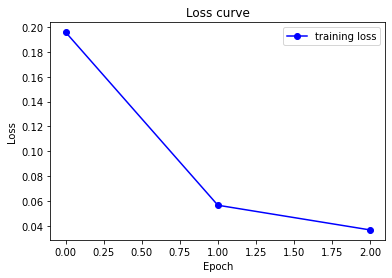

In [ ]:
plt.plot(train_loss_en, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# 5.0. Testing

Since we are done with training, we can apply our fine-tuned model to generate predictions on the test set. 

In [ ]:
testloaders = [testloader_en, testloader_es, testloader_nl, testloader_de, testloader_da, 
               testloader_afr, testloader_sv, testloader_fr, testloader_it, testloader_pt,
               testloader_tr, testloader_ru, testloader_he, testloader_ar, testloader_zh, testloader_ja, testloader_ko]

In [ ]:
def test_model(testloader, model):
  model.eval() #set to evalutation mode 

  predictions = []
  true_labels = []
  
  for counter, data in enumerate(testloader, 0):
    data = tuple(t.to(device) for t in data)
    ids, token_type_ids, mask, tags = data

    with torch.no_grad():
      _, logits = model(ids, mask, token_type_ids=None)
    
    logits = logits.detach().cpu().numpy()
    labels = tags.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(labels)

  return true_labels, predictions

In [ ]:
def compute_accuracy(labels, predictions):
  true_predictions = [
      [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]

  results = f1_score(true_labels, true_predictions)
  report = classification_report(true_labels, true_predictions)
  return results, report

In [ ]:
def test_on_all_languages(model):
  f1_scores = {}
  for i in range(len(testloaders)):
    language = languages[i]
    testloader = testloaders[i]
    labels, predictions = test_model(testloader, model)
    score, report = compute_accuracy(labels, predictions)
    f1_scores[f'{language}'] = score
    print(f"f1 score on {language} test set: {score}")
    print(f"Classification Report {language}:")
    print(report)
    print("------------------------------------------------------------")
  return f1_scores

# The Experiment

# 6.0. Monolingual Models

## 6.1. English

In [ ]:
print("English model results:")
print()
f1_en = test_on_all_languages(model)

English model results:

f1 score on en test set: 0.8825132550418711
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.92      0.88      0.90      2889
        MISC       0.68      0.72      0.70      1225
         ORG       0.87      0.93      0.90      3246
         PER       0.93      0.94      0.93      2639

   micro avg       0.87      0.89      0.88      9999
   macro avg       0.85      0.87      0.86      9999
weighted avg       0.88      0.89      0.88      9999

------------------------------------------------------------
f1 score on es test set: 0.7255437029686596
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.78      0.72      0.75      1704
        MISC       0.22      0.35      0.27       606
         ORG       0.72      0.83      0.77      2347
         PER       0.91      0.93      0.92      1091

   micro avg       0.69      0.76      0.73      5748
   macro avg  

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.573892073892074
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.64      0.67      0.65      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.41      0.35      0.38      7152
         PER       0.73      0.83      0.78      6065

   micro avg       0.54      0.61      0.57     20733
   macro avg       0.45      0.46      0.45     20733
weighted avg       0.59      0.61      0.60     20733

------------------------------------------------------------
f1 score on fr test set: 0.47065577953559584
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.47      0.32      0.38     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.34      0.37      0.35      5746
         PER       0.73      0.86      0.79      6423

   micro avg       0.46      0.48      0.47     22891
   macro avg       0.39      0.39     

In [ ]:
f1_en

{'afr': 0.3968217934165721,
 'ar': 0.30390489382967156,
 'da': 0.638501394978079,
 'de': 0.5485959341882809,
 'en': 0.8825132550418711,
 'es': 0.7255437029686596,
 'fr': 0.47065577953559584,
 'he': 0.48889763890256077,
 'it': 0.5302605890841185,
 'ja': 0.050761156226336264,
 'ko': 0.39711449676823635,
 'nl': 0.6762045024195245,
 'pt': 0.4367231388507984,
 'ru': 0.45465277687687294,
 'sv': 0.573892073892074,
 'tr': 0.4255013431623664,
 'zh': 0.29633343779379506}

## 6.2. Spanish

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)

BertNer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
train_loss_es = train_model(trainloader_es, model, EPOCHS)

EPOCH 1 loss: 0.21093705188040532
EPOCH 2 loss: 0.07027803381933506
EPOCH 3 loss: 0.04919761071923649
TRAINING FINISHED


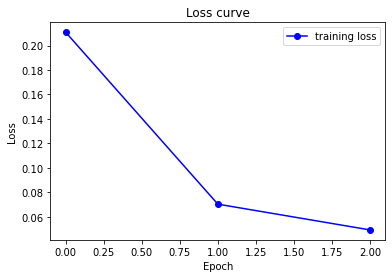

In [ ]:
plt.plot(train_loss_es, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("Spanish model results:")
print()
f1_es = test_on_all_languages(model)

Spanish model results:

f1 score on en test set: 0.5833970507919171
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.64      0.44      0.52      2889
        MISC       0.15      0.15      0.15      1225
         ORG       0.67      0.48      0.56      3246
         PER       0.86      0.88      0.87      2639

   micro avg       0.64      0.53      0.58      9999
   macro avg       0.58      0.49      0.52      9999
weighted avg       0.65      0.53      0.58      9999

------------------------------------------------------------
f1 score on es test set: 0.8648602150537635
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.86      0.86      0.86      1704
        MISC       0.67      0.63      0.65       606
         ORG       0.86      0.91      0.88      2347
         PER       0.93      0.97      0.95      1091

   micro avg       0.86      0.87      0.86      5748
   macro avg  

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.5914480944889285
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.65      0.74      0.69      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.60      0.28      0.39      7152
         PER       0.74      0.82      0.78      6065

   micro avg       0.58      0.61      0.59     20733
   macro avg       0.50      0.46      0.46     20733
weighted avg       0.66      0.61      0.61     20733

------------------------------------------------------------
f1 score on fr test set: 0.5229598693323961
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.50      0.56      0.53     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.43      0.24      0.31      5746
         PER       0.76      0.82      0.79      6423

   micro avg       0.50      0.55      0.52     22891
   macro avg       0.42      0.40     

## 6.3. German

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_de = train_model(trainloader_de, model, EPOCHS)

EPOCH 1 loss: 0.14390246922591032
EPOCH 2 loss: 0.06537264338232406
EPOCH 3 loss: 0.04341795957178048
TRAINING FINISHED


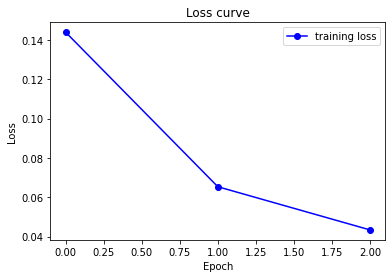

In [ ]:
plt.plot(train_loss_de, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("German model results:")
print()
f1_de = test_on_all_languages(model)

German model results:

f1 score on en test set: 0.5918281381634372
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.48      0.73      0.58      2889
        MISC       0.25      0.04      0.08      1225
         ORG       0.69      0.35      0.46      3246
         PER       0.86      0.88      0.87      2639

   micro avg       0.62      0.56      0.59      9999
   macro avg       0.57      0.50      0.50      9999
weighted avg       0.62      0.56      0.56      9999

------------------------------------------------------------
f1 score on es test set: 0.7226579712699392
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.69      0.82      0.75      1704
        MISC       0.22      0.13      0.16       606
         ORG       0.79      0.68      0.73      2347
         PER       0.86      0.94      0.90      1091

   micro avg       0.73      0.71      0.72      5748
   macro avg   

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.6412795856214479
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.58      0.79      0.66      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.74      0.32      0.45      7152
         PER       0.78      0.85      0.81      6065

   micro avg       0.64      0.64      0.64     20733
   macro avg       0.52      0.49      0.48     20733
weighted avg       0.69      0.64      0.63     20733

------------------------------------------------------------
f1 score on fr test set: 0.6023515603713873
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.53      0.68      0.60     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.48      0.27      0.35      5746
         PER       0.78      0.86      0.82      6423

   micro avg       0.58      0.63      0.60     22891
   macro avg       0.45      0.45     

# 7.0. Bilingual Models

In [ ]:
def merge_2_datasets(dataset1, dataset2):

  len1 = len(dataset1)
  len2 = len(dataset2)

  df1 = shuffle(dataset1)
  df2 = shuffle(dataset2)

  df_row_merged = pd.concat([df1[:round(len1/2)], df2[:round(len2/2)]], ignore_index=True)
  df = pd.DataFrame(df_row_merged) 

  # shuffle the DataFrame rows 
  df = df.sample(frac = 1) 

  return df

def create_trainloader(df_train):
  ids_train = torch.tensor(df_train["input_ids"].tolist(), dtype=torch.long)
  token_type_ids_train = torch.tensor(df_train["token_type_ids"].tolist(), dtype=torch.long)
  mask_train = torch.tensor(df_train["attention_mask"].tolist(), dtype=torch.long)
  tags_train = torch.tensor(df_train["ner_tags"].tolist(), dtype=torch.long)

  trainset = TensorDataset(ids_train, token_type_ids_train, mask_train, tags_train)

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)

  return trainloader

In [ ]:
df_en_es = merge_2_datasets(df_en_train, df_es_train)
df_en_de = merge_2_datasets(df_en_train, df_de_train)
df_es_fr = merge_2_datasets(df_es_train, df_fr_train)
df_en_zh = merge_2_datasets(df_en_train, df_zh_train)
df_en_es

,attention_mask,input_ids,ner_tags,token_type_ids,tokens
9567,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 118, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 0, -100, -100, -100, -100, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-]
737,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 107, 10377, 112, 187, 169, 53510, 117, 1...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","["", It, 's, a, possibility, ,, not, a, probabi..."
9282,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 17840, 50773, 10113, 10109, 89801, 10121...","[-100, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[González, Ortea, lamentó, que, se, acusara, a..."
7915,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 16532, 26978, 100816, 25235, 10109, 1379...","[-100, 0, 0, 0, 0, 0, 3, 3, 3, 4, 4, 4, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Según, informó, hoy, la, Jefatura, Superior, ..."
9536,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 67205, 117, 193, 16029, 10173, 49343, 11...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Asimismo, ,, y, según, confirmaron, fuentes, ..."
...,...,...,...,...,...
1112,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10117, 103559, 92710, 10891, 10309, 1014...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[The, soybeans, were, for, Oct, 15-30, shipmen..."
2813,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10117, 92031, 112, 187, 34316, 12990, 28...","[-100, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[The, SEC, 's, limit, order, display, rule, wi..."
8207,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 18626, 10109, 72710, 13771, 10104, 12028...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Tras, la, ceremonia, oficial, de, bienvenida,..."
3428,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 19319, 33199, 21937, 46617, 10189, 10105...","[-100, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Birnberg, told, Reuters, that, the, challenge..."


In [ ]:
trainloader_en_es = create_trainloader(df_en_es)
trainloader_en_de = create_trainloader(df_en_de)
trainloader_es_fr = create_trainloader(df_es_fr)
trainloader_en_zh = create_trainloader(df_en_zh)

## 7.1. English-Spanish

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_en_es = train_model(trainloader_en_es, model, EPOCHS)

EPOCH 1 loss: 0.23234324214713914
EPOCH 2 loss: 0.07538522097149065
EPOCH 3 loss: 0.04896357262374035
TRAINING FINISHED


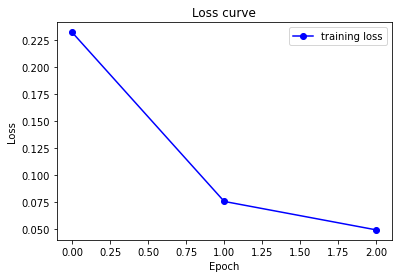

In [ ]:
plt.plot(train_loss_en_es, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("English-Spanish model results:")
print()
f1_en_es = test_on_all_languages(model)

English-Spanish model results:

f1 score on en test set: 0.8781858516144935
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.87      0.93      0.90      2889
        MISC       0.69      0.72      0.70      1225
         ORG       0.88      0.89      0.89      3246
         PER       0.92      0.93      0.93      2639

   micro avg       0.87      0.89      0.88      9999
   macro avg       0.84      0.87      0.85      9999
weighted avg       0.87      0.89      0.88      9999

------------------------------------------------------------
f1 score on es test set: 0.8501068832834544
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.85      0.84      0.85      1704
        MISC       0.62      0.63      0.62       606
         ORG       0.84      0.90      0.87      2347
         PER       0.93      0.96      0.95      1091

   micro avg       0.84      0.86      0.85      5748
   mac

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.5730602851237028
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.64      0.79      0.71      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.34      0.35      0.34      7152
         PER       0.75      0.83      0.78      6065

   micro avg       0.51      0.65      0.57     20733
   macro avg       0.43      0.49      0.46     20733
weighted avg       0.57      0.65      0.60     20733

------------------------------------------------------------
f1 score on fr test set: 0.5953503429577323
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.59      0.69      0.64     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.42      0.34      0.37      5746
         PER       0.80      0.84      0.82      6423

   micro avg       0.55      0.64      0.60     22891
   macro avg       0.45      0.47     

## 7.2. English-German

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_en_de = train_model(trainloader_en_de, model, EPOCHS)

EPOCH 1 loss: 0.18034252068759973
EPOCH 2 loss: 0.07077068762625593
EPOCH 3 loss: 0.04489039426832928
TRAINING FINISHED


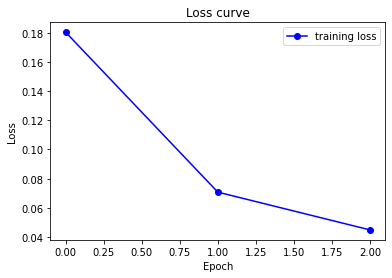

In [ ]:
plt.plot(train_loss_en_de, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("English-German model results:")
print()
f1_en_de = test_on_all_languages(model)

English-German model results:

f1 score on en test set: 0.8838984731310727
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.92      0.91      0.91      2889
        MISC       0.64      0.74      0.69      1225
         ORG       0.89      0.90      0.89      3246
         PER       0.95      0.93      0.94      2639

   micro avg       0.88      0.89      0.88      9999
   macro avg       0.85      0.87      0.86      9999
weighted avg       0.88      0.89      0.89      9999

------------------------------------------------------------
f1 score on es test set: 0.7579612396482541
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.73      0.88      0.80      1704
        MISC       0.28      0.19      0.23       606
         ORG       0.76      0.78      0.77      2347
         PER       0.91      0.92      0.92      1091

   micro avg       0.74      0.77      0.76      5748
   macr

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.6102661183280023
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.61      0.81      0.70      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.41      0.39      0.40      7152
         PER       0.76      0.86      0.81      6065

   micro avg       0.56      0.68      0.61     20733
   macro avg       0.45      0.51      0.48     20733
weighted avg       0.59      0.68      0.63     20733

------------------------------------------------------------
f1 score on fr test set: 0.5971434956624204
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.57      0.64      0.60     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.43      0.40      0.41      5746
         PER       0.75      0.86      0.80      6423

   micro avg       0.56      0.64      0.60     22891
   macro avg       0.44      0.48     

## 7.3. Spanish-French

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_es_fr = train_model(trainloader_es_fr, model, EPOCHS)

EPOCH 1 loss: 0.30015018628594836
EPOCH 2 loss: 0.12310654256686265
EPOCH 3 loss: 0.0833219082197742
TRAINING FINISHED


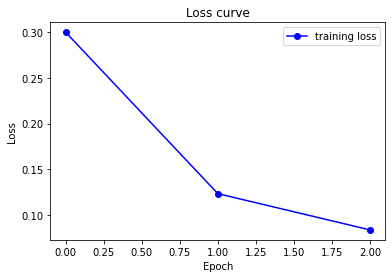

In [ ]:
plt.plot(train_loss_es_fr, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("Spanish-French model results:")
print()
f1_es_fr = test_on_all_languages(model)

Spanish-French model results:

f1 score on en test set: 0.5807222914072229
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.67      0.32      0.43      2889
        MISC       0.20      0.16      0.17      1225
         ORG       0.49      0.75      0.59      3246
         PER       0.83      0.87      0.85      2639

   micro avg       0.58      0.58      0.58      9999
   macro avg       0.55      0.52      0.51      9999
weighted avg       0.60      0.58      0.56      9999

------------------------------------------------------------
f1 score on es test set: 0.8355510064824291
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.86      0.78      0.82      1704
        MISC       0.52      0.59      0.55       606
         ORG       0.83      0.92      0.87      2347
         PER       0.93      0.95      0.94      1091

   micro avg       0.82      0.85      0.84      5748
   macr

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.7554438860971525
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.72      0.77      0.75      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.70      0.64      0.67      7152
         PER       0.85      0.89      0.87      6065

   micro avg       0.75      0.76      0.76     20733
   macro avg       0.57      0.58      0.57     20733
weighted avg       0.75      0.76      0.76     20733

------------------------------------------------------------
f1 score on fr test set: 0.8865157029836759
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.91      0.90      0.90     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.80      0.84      0.82      5746
         PER       0.92      0.92      0.92      6423

   micro avg       0.88      0.89      0.89     22891
   macro avg       0.66      0.66     

## 7.4. English-Chinese

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_en_zh = train_model(trainloader_en_zh, model, EPOCHS)

EPOCH 1 loss: 0.0943852259453592
EPOCH 2 loss: 0.032747451352704224
EPOCH 3 loss: 0.021502747981976073
TRAINING FINISHED


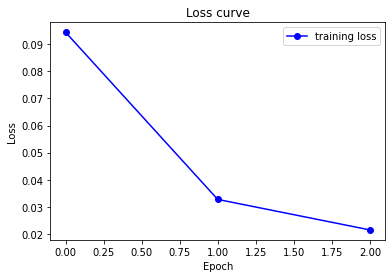

In [ ]:
plt.plot(train_loss_en_zh, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("English-Chinese model results:")
print()
f1_en_zh = test_on_all_languages(model)

English-Chinese model results:

f1 score on en test set: 0.8823037164656659
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.90      0.93      0.91      2889
        MISC       0.70      0.73      0.71      1225
         ORG       0.87      0.89      0.88      3246
         PER       0.91      0.94      0.93      2639

   micro avg       0.87      0.90      0.88      9999
   macro avg       0.85      0.87      0.86      9999
weighted avg       0.87      0.90      0.88      9999

------------------------------------------------------------
f1 score on es test set: 0.6937806873977087
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.61      0.83      0.70      1704
        MISC       0.24      0.30      0.27       606
         ORG       0.74      0.69      0.72      2347
         PER       0.84      0.92      0.88      1091

   micro avg       0.65      0.74      0.69      5748
   mac

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.5721770427572384
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.54      0.72      0.62      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.44      0.28      0.34      7152
         PER       0.71      0.84      0.77      6065

   micro avg       0.54      0.61      0.57     20733
   macro avg       0.42      0.46      0.43     20733
weighted avg       0.56      0.61      0.57     20733

------------------------------------------------------------
f1 score on fr test set: 0.5452665536209107
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.50      0.52      0.51     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.42      0.36      0.39      5746
         PER       0.74      0.86      0.79      6423

   micro avg       0.52      0.58      0.55     22891
   macro avg       0.41      0.44     

# 8.0. Trilingual Models

In [ ]:
def merge_3_datasets(dataset1, dataset2, dataset3):

  len1 = len(dataset1)
  len2 = len(dataset2)
  len3 = len(dataset3)

  df1 = shuffle(dataset1)
  df2 = shuffle(dataset2)
  df3 = shuffle(dataset3)

  pdList = [df1[:round(len1/3)], df2[:round(len2/3)], df3[:round(len3/3)]]
  new_df = pd.concat(pdList, ignore_index= True)

  df = pd.DataFrame(new_df) 

  # shuffle the DataFrame rows 
  df = df.sample(frac = 1) 

  return df

In [ ]:
df_en_es_de = merge_3_datasets(df_en_train, df_es_train, df_de_train)
df_en_ru_zh = merge_3_datasets(df_en_train, df_ru_train, df_zh_train)
df_da_ar_ja = merge_3_datasets(df_da_train, df_ar_train, df_ja_train)

In [ ]:
trainloader_en_es_de = create_trainloader(df_en_es_de)
trainloader_en_ru_zh = create_trainloader(df_en_ru_zh)
trainloader_da_ar_ja = create_trainloader(df_da_ar_ja)

## 8.1. English-Spanish-German

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_en_es_de = train_model(trainloader_en_es_de, model, EPOCHS)

EPOCH 1 loss: 0.1928119021962372
EPOCH 2 loss: 0.07749128191262088
EPOCH 3 loss: 0.05099623152611167
TRAINING FINISHED


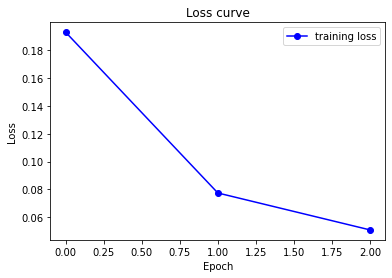

In [ ]:
plt.plot(train_loss_en_es_de, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("English-Spanish-German model results:")
print()
f1_en_es_de = test_on_all_languages(model)

English-Spanish-German model results:

f1 score on en test set: 0.8741655873268905
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.93      0.89      0.91      2889
        MISC       0.71      0.68      0.70      1225
         ORG       0.82      0.93      0.87      3246
         PER       0.96      0.89      0.93      2639

   micro avg       0.87      0.88      0.87      9999
   macro avg       0.85      0.85      0.85      9999
weighted avg       0.87      0.88      0.87      9999

------------------------------------------------------------
f1 score on es test set: 0.8330757341576508
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.87      0.78      0.83      1704
        MISC       0.59      0.65      0.62       606
         ORG       0.80      0.90      0.84      2347
         PER       0.97      0.94      0.95      1091

   micro avg       0.82      0.84      0.83      5748

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.6028066959121762
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.67      0.80      0.73      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.38      0.41      0.39      7152
         PER       0.81      0.80      0.81      6065

   micro avg       0.55      0.67      0.60     20733
   macro avg       0.46      0.50      0.48     20733
weighted avg       0.61      0.67      0.64     20733

------------------------------------------------------------
f1 score on fr test set: 0.5847610186290175
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.58      0.63      0.60     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.40      0.43      0.42      5746
         PER       0.81      0.81      0.81      6423

   micro avg       0.54      0.63      0.58     22891
   macro avg       0.45      0.47     

## 8.2. English-Russian-Chinese

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_en_ru_zh = train_model(trainloader_en_ru_zh, model, EPOCHS)

EPOCH 1 loss: 0.1434663195859243
EPOCH 2 loss: 0.055676741525530815
EPOCH 3 loss: 0.03630146477145405
TRAINING FINISHED


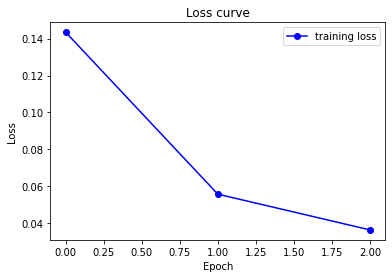

In [ ]:
plt.plot(train_loss_en_ru_zh, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("English-Russian-Chinese model results:")
print()
f1_en_ru_zh = test_on_all_languages(model)

English-Russian-Chinese model results:

f1 score on en test set: 0.8656847873954103
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.87      0.92      0.90      2889
        MISC       0.75      0.70      0.73      1225
         ORG       0.81      0.90      0.86      3246
         PER       0.90      0.90      0.90      2639

   micro avg       0.85      0.88      0.87      9999
   macro avg       0.84      0.86      0.85      9999
weighted avg       0.85      0.88      0.86      9999

------------------------------------------------------------
f1 score on es test set: 0.7041525574763857
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.66      0.82      0.73      1704
        MISC       0.38      0.08      0.14       606
         ORG       0.71      0.63      0.67      2347
         PER       0.92      0.93      0.92      1091

   micro avg       0.72      0.69      0.70      574

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.6841458418680868
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.64      0.81      0.72      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.55      0.58      0.56      7152
         PER       0.79      0.79      0.79      6065

   micro avg       0.65      0.72      0.68     20733
   macro avg       0.50      0.55      0.52     20733
weighted avg       0.66      0.72      0.69     20733

------------------------------------------------------------
f1 score on fr test set: 0.7048200222652868
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.68      0.75      0.72     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.50      0.67      0.57      5746
         PER       0.86      0.80      0.83      6423

   micro avg       0.67      0.75      0.70     22891
   macro avg       0.51      0.56     

## 8.3. Danish-Arabic-Japanese

In [ ]:
model = BertNer(NUM_LABELS)
model.to(device)
train_loss_da_ar_ja = train_model(trainloader_da_ar_ja, model, EPOCHS)

EPOCH 1 loss: 0.4685259178506118
EPOCH 2 loss: 0.27012529161398663
EPOCH 3 loss: 0.20444210208389207
TRAINING FINISHED


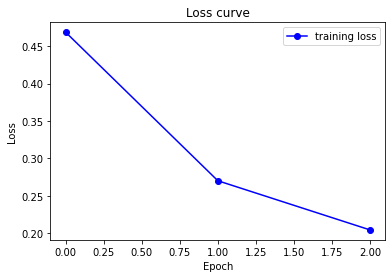

In [ ]:
plt.plot(train_loss_da_ar_ja, 'b-o', label = "training loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
print("Danish-Arabic-Japanese model results:")
print()
f1_da_ar_ja = test_on_all_languages(model)

Danish-Arabic-Japanese model results:

f1 score on en test set: 0.5406663261252057
Classification Report en:
              precision    recall  f1-score   support

         LOC       0.53      0.36      0.43      2889
        MISC       0.51      0.40      0.45      1225
         ORG       0.54      0.37      0.44      3246
         PER       0.83      0.77      0.80      2639

   micro avg       0.63      0.48      0.54      9999
   macro avg       0.60      0.48      0.53      9999
weighted avg       0.61      0.48      0.53      9999

------------------------------------------------------------
f1 score on es test set: 0.5457540565027593
Classification Report es:
              precision    recall  f1-score   support

         LOC       0.54      0.62      0.58      1704
        MISC       0.01      0.01      0.01       606
         ORG       0.51      0.57      0.54      2347
         PER       0.84      0.84      0.84      1091

   micro avg       0.52      0.58      0.55      5748

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score on sv test set: 0.5791523802859609
Classification Report sv:
              precision    recall  f1-score   support

         LOC       0.41      0.46      0.44      7516
        MISC       0.00      0.00      0.00         0
         ORG       0.60      0.51      0.55      7152
         PER       0.83      0.87      0.85      6065

   micro avg       0.56      0.60      0.58     20733
   macro avg       0.46      0.46      0.46     20733
weighted avg       0.60      0.60      0.60     20733

------------------------------------------------------------
f1 score on fr test set: 0.7014870738961335
Classification Report fr:
              precision    recall  f1-score   support

         LOC       0.75      0.59      0.66     10722
        MISC       0.00      0.00      0.00         0
         ORG       0.66      0.66      0.66      5746
         PER       0.80      0.82      0.81      6423

   micro avg       0.74      0.67      0.70     22891
   macro avg       0.55      0.52     

# 9.0. Results

In this section we show the f1 score achieved on all the chosen languages by each training combination.

In [ ]:
results = [f1_en, f1_es, f1_de, f1_en_es, f1_en_de, f1_es_fr, f1_en_zh, f1_en_es_de, f1_en_ru_zh, f1_da_ar_ja]
results

[{'afr': 0.3968217934165721,
  'ar': 0.30390489382967156,
  'da': 0.638501394978079,
  'de': 0.5485959341882809,
  'en': 0.8825132550418711,
  'es': 0.7255437029686596,
  'fr': 0.47065577953559584,
  'he': 0.48889763890256077,
  'it': 0.5302605890841185,
  'ja': 0.050761156226336264,
  'ko': 0.39711449676823635,
  'nl': 0.6762045024195245,
  'pt': 0.4367231388507984,
  'ru': 0.45465277687687294,
  'sv': 0.573892073892074,
  'tr': 0.4255013431623664,
  'zh': 0.29633343779379506},
 {'afr': 0.4617422312786551,
  'ar': 0.29850858127857305,
  'da': 0.640439932318105,
  'de': 0.5915321352421565,
  'en': 0.5833970507919171,
  'es': 0.8648602150537635,
  'fr': 0.5229598693323961,
  'he': 0.4996774382734151,
  'it': 0.5244142445774895,
  'ja': 0.016041578171459982,
  'ko': 0.4564981156505052,
  'nl': 0.625963161370808,
  'pt': 0.5237741131184113,
  'ru': 0.46179735705806385,
  'sv': 0.5914480944889285,
  'tr': 0.5231106643516403,
  'zh': 0.09672600522843272},
 {'afr': 0.3811144193960017,
  'ar'

In [ ]:
results_df = pd.DataFrame(results)
results_df.insert(0, 'training languages', ['en', 'es', 'de', 'en-es', 'en-de', 'es-fr', 'en-zh', 'en-es-de', 'en-ru-zh', 'da-ar-ja'])
results_df

,training languages,en,es,nl,de,da,afr,sv,fr,it,pt,tr,ru,he,ar,zh,ja,ko
0,en,0.882513,0.725544,0.676205,0.548596,0.638501,0.396822,0.573892,0.470656,0.530261,0.436723,0.425501,0.454653,0.488898,0.303905,0.296333,0.050761,0.397114
1,es,0.583397,0.864860,0.625963,0.591532,0.640440,0.461742,0.591448,0.522960,0.524414,0.523774,0.523111,0.461797,0.499677,0.298509,0.096726,0.016042,0.456498
2,de,0.591828,0.722658,0.653941,0.820562,0.618775,0.381114,0.641280,0.602352,0.612613,0.582538,0.584694,0.517811,0.533279,0.345585,0.133964,0.019243,0.520709
3,en-es,0.878186,0.850107,0.700062,0.552779,0.670120,0.480336,0.573060,0.595350,0.581491,0.527868,0.540638,0.486240,0.508656,0.328172,0.135436,0.024024,0.482855
4,en-de,0.883898,0.757961,0.676561,0.814523,0.666384,0.432544,0.610266,0.597143,0.591328,0.533413,0.536750,0.552580,0.559682,0.356030,0.211380,0.030978,0.520383
5,es-fr,0.580722,0.835551,0.540941,0.554355,0.615076,0.404561,0.755444,0.886516,0.781366,0.825278,0.610603,0.650863,0.557905,0.481937,0.132491,0.065386,0.571909
6,en-zh,0.882304,0.693781,0.655244,0.616017,0.582015,0.325593,0.572177,0.545267,0.565864,0.490717,0.410947,0.465326,0.457664,0.349847,0.912668,0.353499,0.228017
7,en-es-de,0.874166,0.833076,0.641673,0.798714,0.700855,0.472809,0.602807,0.584761,0.576073,0.539649,0.546846,0.549837,0.518306,0.323162,0.113300,0.010354,0.511687
8,en-ru-zh,0.865685,0.704153,0.627833,0.615820,0.646938,0.341007,0.684146,0.704820,0.701652,0.668789,0.562239,0.876663,0.566952,0.399959,0.903079,0.340592,0.448754
9,da-ar-ja,0.540666,0.545754,0.626405,0.534481,0.734848,0.336779,0.579152,0.701487,0.717720,0.743768,0.595448,0.507708,0.581282,0.835143,0.377319,0.649550,0.388184
